In [2]:
%pip install opencv-python
%pip install sci-kit-image

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement sci-kit-image (from versions: none)
ERROR: No matching distribution found for sci-kit-image
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
import cv2
import scipy
import skimage
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

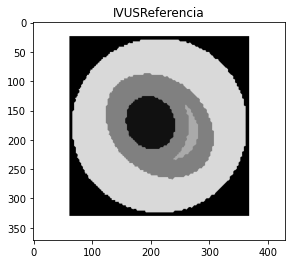

In [4]:
ivus_referencia = cv2.imread('../imagens/IVUSReferencia.pgm', 0) # Gray
ivus_referencia = skimage.img_as_float(ivus_referencia)
plt.figure()
plt.title('IVUSReferencia')
plt.imshow(ivus_referencia, cmap='gray')

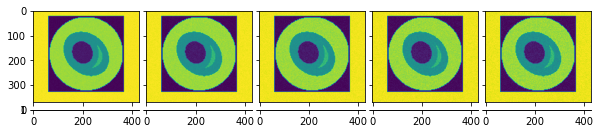

In [5]:
f_noise = list()
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 5),
                 axes_pad=0.1,
                 )
for i in range(1, 6):
    f_noise.append(
        skimage.util.random_noise(
            image=ivus_referencia,
            var=i*0.001,
            mode='gaussian',
        )
    )
    grid[i-1].imshow(f_noise[i-1])

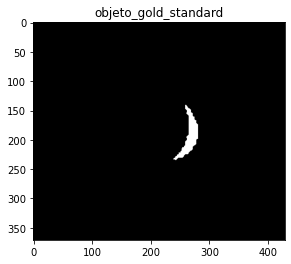

In [6]:
objeto_gold_standard = cv2.imread('../imagens/ObjetoGoldStandard.pgm', 0) # Gray
objeto_gold_standard = skimage.img_as_float(objeto_gold_standard) 
plt.figure()
plt.title('objeto_gold_standard')
plt.imshow(objeto_gold_standard, cmap='gray')

In [7]:
threshold = 0.5
objeto_gold_standard_bin = objeto_gold_standard > threshold

In [8]:
thresh = skimage.filters.threshold_otsu(objeto_gold_standard)
thresh

0.001953125

In [9]:
roi = cv2.selectROI(ivus_referencia)

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x56245e67a1d0) is not the object's thread (0x56245f223c20).
Cannot move to target thread (0x56245e67a1d0)

QObject::moveToThread: Current thread (0x56245e67a1d0) is not the object's thread (0x56245f223c20).
Cannot move to target thread (0x56245e67a1d0)

QObject::moveToThread: Current thread (0x56245e67a1d0) is not the object's thread (0x56245f223c20).
Cannot move to target thread (0x56245e67a1d0)

QObject::moveToThread: Current thread (0x56245e67a1d0) is not the object's thread (0x56245f223c20).
Cannot move to target thread (0x56245e67a1d0)

QObject::moveToThread: Current thread (0x56245e67a1d0) is not the object's thread (0x56245f223c20).
Cannot move to target thread (0x56245e67a1d0)

QObject::moveToThread: Current thread (0x56245e67a1d0) is not the object's thread (0x56245f223c20).
Cannot move to target thread (0x56245e67a1d0)

QObject::moveToThread: Current thread (0x56245e67a1d0) is not the object's thread (0x56245f223c20).
Cannot move to tar

In [10]:
c_min = roi[0]
l_min = roi[1]
c_max = roi[0] + roi[2]
l_max = roi[1] + roi[3]
variancia_homogenia = np.var(ivus_referencia[l_min:c_min, l_max:c_max])
media = np.mean(ivus_referencia[l_min:c_min, l_max:c_max])
desvio_padrao = np.std(ivus_referencia[l_min:c_min, l_max:c_max])


In [11]:
c_min

261

In [12]:
desvio_padrao

0.26501131588304333

In [13]:
(M,N) = np.shape(ivus_referencia)
k = np.zeros_like(ivus_referencia)

In [14]:
for m in range(M):
    for n in range(N):
        if ivus_referencia[m,n] >= (media-0.5*desvio_padrao) and ivus_referencia[m,n] <= (media+0.5*desvio_padrao):
            k[m,n] = ivus_referencia[m,n]

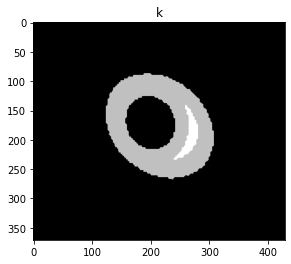

In [15]:
plt.figure()
plt.title('k')
plt.imshow(k, cmap='gray')

In [16]:
variancia_homogenia

0.07023099754606217